In [14]:
import torch
import torch.nn.functional as F
from transformers import WhisperProcessor, WhisperModel

import sys
import numpy as np

import torchaudio
from torch.utils.data import DataLoader

from colorama import Fore, Style

#from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter


In [3]:
LABELS = ["bed", "bird", "cat", "dog", "down", "eight", 
          "five", "four", "go", "happy", "house", "left", 
          "marvin", "nine", "no", "off", "on", "one", "right",
          "seven", "sheila", "six", "stop", "three", "tree",
          "two", "up","wow", "yes", "zero"]

def label2id(label):
    return torch.tensor(LABELS.index(label))

def id2label(id):
    return LABELS[id]

def label_to_index(label):
    return torch.tensor(LABELS.index(label))

In [4]:
sample_rate = 16000
batch_size = 24
learning_rate = 0.001
epochs = 5

In [5]:
processor = WhisperProcessor.from_pretrained("openai/whisper-small")

In [6]:
def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [processor(waveform.squeeze(0), sampling_rate=sample_rate, return_tensors="pt").input_features]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = torch.stack(tensors)
    #print("tensors:", tensors.shape)
    #tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets

def get_dataloader(batch_size=16):
    #dataset = torchaudio.datasets.SPEECHCOMMANDS(root = "./data", 
    #                                url = 'speech_commands_v0.01', 
    #                                folder_in_archive = 'SpeechCommands', 
    #                                download = False, 
    #                                subset = None)
    
    train_dataset = torchaudio.datasets.SPEECHCOMMANDS(root = "./data", 
                                    url = 'speech_commands_v0.01', 
                                    folder_in_archive = 'SpeechCommands', 
                                    download = False, 
                                    subset = "training")

    #print(len(train_dataset))

    val_dataset = torchaudio.datasets.SPEECHCOMMANDS(root = "./data", 
                                    url = 'speech_commands_v0.01', 
                                    folder_in_archive = 'SpeechCommands', 
                                    download = False, 
                                    subset = "validation")
    #print(len(val_dataset))

    test_dataset = torchaudio.datasets.SPEECHCOMMANDS(root = "./data", 
                                    url = 'speech_commands_v0.01', 
                                    folder_in_archive = 'SpeechCommands', 
                                    download = False, 
                                    subset = "testing")
    #print(len(test_dataset))

    train_dataset = torch.utils.data.ConcatDataset([train_dataset, val_dataset])
    #print(len(train_dataset))

    #test_dataset1, test_dataset2 = torch.utils.data.random_split(test_dataset, [200, 6635])
    
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    #labels = [datapoint[2] for datapoint in dataset]
    #labels = sorted(list(set(labels)))
    
    return train_dataloader, val_dataloader #, labels

def freeze(model):
    for param in model.parameters():
        param.requires_grad = False
    return model

In [7]:
class speechClassificationModel(torch.nn.Module):
    def __init__(self, classes=30):
        super().__init__()
        base = WhisperModel.from_pretrained(".")
        self.base = freeze(base)
        self.base.config.forced_decoder_ids = None
        self.decoder_start_token_id = self.base.config.decoder_start_token_id
        self.classifier = torch.nn.Linear(768, classes)

    def forward(self, input_features, decoder_input_ids):
        lhs = self.base(input_features, decoder_input_ids=decoder_input_ids)
        last_hidden_state = lhs.last_hidden_state
        
        #print("last hidden state:", last_hidden_state.shape)
        last_hidden_state = torch.mean(last_hidden_state, axis=1)
        #print("last hidden state:", last_hidden_state.shape)
        last_hidden_state = last_hidden_state.view(-1, 768)
        #print("last hidden state:", last_hidden_state.shape)
        x = self.classifier(last_hidden_state)
        #print("x:", x.shape)
        return x

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = speechClassificationModel(classes = 30).to(device)

In [10]:
train_dataloader, val_dataloader = get_dataloader(batch_size=batch_size)
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9,0.999))

In [9]:
import sys

def train_onestep(model, optimizer, criterion, dataloader, device):
    
    epoch_loss = []
    acc = []
    total_iter = len(dataloader)
    model.train()
    for iter, (wav, label) in enumerate(dataloader):
        input_features = wav.squeeze(1).to(device)
        label = label.to(device)
        token = torch.ones((input_features.shape[0],5)).type(torch.LongTensor)
        decoder_input_ids = (token * model.base.config.decoder_start_token_id).to(device)

        optimizer.zero_grad()
        outputs = model(input_features=input_features, decoder_input_ids=decoder_input_ids)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        yhat = F.softmax(outputs, dim=1)
        _, yhat = torch.max(yhat, dim=1)

        #print("predicted:", yhat)
        #print("actual:", label)
        
        epoch_loss.append(loss.item())
        acc.append((torch.sum(yhat==label)/yhat.shape[0]).item())
        
        sys.stdout.write(f"\r[{iter}/{total_iter}] epoch loss: {np.mean(epoch_loss)} accuracy: {np.mean(acc)}")

    return np.mean(epoch_loss), np.mean(acc)
        
        
        

In [10]:
def eval_model(model, criterion, val_dataloader, device):
    
    epoch_loss = []
    acc = []
    total_iter = len(val_dataloader)
    print("\n=============== EVALUATION =================")
    model.eval()
    with torch.set_grad_enabled(False):
        for iter, (wav, label) in enumerate(val_dataloader):
            input_features = wav.squeeze(1).to(device)
            label = label.to(device)
            token = torch.ones((input_features.shape[0],5)).type(torch.LongTensor)
            decoder_input_ids = (token * model.base.config.decoder_start_token_id).to(device)

            outputs = model(input_features=input_features, decoder_input_ids=decoder_input_ids)
            loss = criterion(outputs, label)

            yhat = F.softmax(outputs, dim=1)
            _, yhat = torch.max(yhat, dim=1)

            #print("predicted:", yhat)
            #print("actual:", label)
            
            epoch_loss.append(loss.item())
            acc.append((torch.sum(yhat==label)/yhat.shape[0]).item())
            
            sys.stdout.write(f"\r[{iter}/{total_iter}] val loss: {np.mean(epoch_loss)} val accuracy: {np.mean(acc)}")

    return np.mean(epoch_loss), np.mean(acc)

In [11]:
#from IPython.display import display, clear_output

def train():
    train_losses = []
    train_accuracy = []
    val_losses = []
    val_accuracy = []

    best_accuracy = -1
    writer = SummaryWriter()
    
    for epoch in range(epochs):
        tloss, tacc = train_onestep(model, optimizer, criterion, train_dataloader, device)
        vloss, vacc = eval_model(model, criterion, val_dataloader, device)
        train_losses.append(tloss), train_accuracy.append(tacc), val_losses.append(vloss), val_accuracy.append(vacc)
        
        writer.add_scalar("Loss/train", tloss, epoch)
        writer.add_scalar("Loss/val", vloss, epoch)
        writer.add_scalar("Accuracy/train", tacc, epoch)
        writer.add_scalar("Accuracy/val", vacc, epoch)
        
        if vacc > best_accuracy:
            print("Saving best model weights...")
            best_accuracy = vacc
            torch.save(model.state_dict(), "./whisper-small-ft.pt")
    
    writer.flush()

    

In [12]:
train()

[2411/2412] epoch loss: 0.28037522495241246 accuracy: 0.9398807920654546
=============== EVALUATION =================
[284/285] val loss: 0.1839893241649853 val accuracy: 0.95961066630848679Saving best model weights...
[2411/2412] epoch loss: 0.16589079237375887 accuracy: 0.9636508298305729
=============== EVALUATION =================
[284/285] val loss: 0.1527629717585545 val accuracy: 0.9664435384566323Saving best model weights...
[2411/2412] epoch loss: 0.16496480343843054 accuracy: 0.9665215763434842
=============== EVALUATION =================
[284/285] val loss: 0.21127594770028385 val accuracy: 0.9597953407387985Saving best model weights...
[2411/2412] epoch loss: 0.1574322455759991 accuracy: 0.96892119415265014
=============== EVALUATION =================
[284/285] val loss: 0.22141886763908525 val accuracy: 0.9599030659909834Saving best model weights...
[2411/2412] epoch loss: 0.15377515108907483 accuracy: 0.9705968431720686
=============== EVALUATION =================
[284/28

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = speechClassificationModel(classes = 30).to(device)

In [9]:
model.load_state_dict(torch.load("./whisper-small-ft.pt"))

<All keys matched successfully>

In [17]:
def eval(model, criterion, val_dataloader, device):
    
    epoch_loss = []
    acc = []
    total_iter = len(val_dataloader)
    print("\n=============== EVALUATION =================")
    predicted = []
    actual = []
    model.eval()
    with torch.set_grad_enabled(False):
        for iter, (wav, label) in enumerate(val_dataloader):
            input_features = wav.squeeze(1).to(device)
            label = label.to(device)
            token = torch.ones((input_features.shape[0],5)).type(torch.LongTensor)
            decoder_input_ids = (token * model.base.config.decoder_start_token_id).to(device)

            outputs = model(input_features=input_features, decoder_input_ids=decoder_input_ids)
            loss = criterion(outputs, label)

            yhat = F.softmax(outputs, dim=1)
            _, yhat = torch.max(yhat, dim=1)

            acc.append((torch.sum(yhat==label)/yhat.shape[0]).item())
            
            yhat = [x.item() for x in yhat]
            label = [x.item() for x in label]
            predicted.extend(yhat)
            actual.extend(label)
            #print("predicted:", predicted)
            #print("actual:", actual)
            
            epoch_loss.append(loss.item())
                        
            sys.stdout.write(f"\r[{iter}/{total_iter}] val loss: {np.mean(epoch_loss)} val accuracy: {np.mean(acc)}")

    return actual, predicted

In [18]:
actual, predicted = eval(model, criterion, val_dataloader, device)


=============== EVALUATION =================
[284/285] val loss: 0.2184495316529217 val accuracy: 0.96330411225034489

In [20]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(actual, predicted)

In [21]:
matrix = np.array(matrix)

In [22]:
matrix.shape

(30, 30)

In [23]:
matrix

array([[170,   0,   0,   0,   0,   0,   0,   0,   0,   3,   0,   1,   1,
          0,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0],
       [  2, 154,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
          0,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0],
       [  0,   0, 158,   0,   0,   0,   0,   0,   0,   4,   0,   0,   2,
          0,   1,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,
          0,   0,   0,   0],
       [  0,   0,   0, 178,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   1,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,
          0,   0,   0,   0],
       [  0,   0,   0,   0, 248,   0,   0,   0,   0,   5,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 249,   0,   0,   0,   3,   0,   0,   0,
          0,   2,   0,   2,   0,   0,   0,   0,   0,

In [24]:
import pandas as pd
import seaborn as sns

In [28]:
data = pd.DataFrame(matrix, columns=LABELS)
data.head()

,bed,bird,cat,dog,down,eight,five,four,go,happy,...,sheila,six,stop,three,tree,two,up,wow,yes,zero
0,170,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
1,2,154,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,158,0,0,0,0,0,0,4,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,178,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,248,0,0,0,0,5,...,0,0,0,0,0,0,0,0,0,0


In [29]:
data.index = LABELS

In [30]:
data

,bed,bird,cat,dog,down,eight,five,four,go,happy,...,sheila,six,stop,three,tree,two,up,wow,yes,zero
bed,170,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
bird,2,154,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
cat,0,0,158,0,0,0,0,0,0,4,...,0,0,1,0,0,0,0,0,0,0
dog,0,0,0,178,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
down,0,0,0,0,248,0,0,0,0,5,...,0,0,0,0,0,0,0,0,0,0
eight,0,0,0,0,0,249,0,0,0,3,...,0,0,0,0,0,0,0,0,0,1
five,0,0,0,0,0,0,265,0,0,0,...,0,0,0,1,0,0,0,0,0,1
four,0,3,0,0,0,0,0,233,0,2,...,0,1,0,5,0,0,0,0,2,0
go,0,0,0,2,0,0,0,0,243,1,...,0,0,0,0,0,0,0,0,0,1
happy,0,0,1,0,0,0,0,0,0,179,...,0,0,0,0,0,0,0,0,0,0


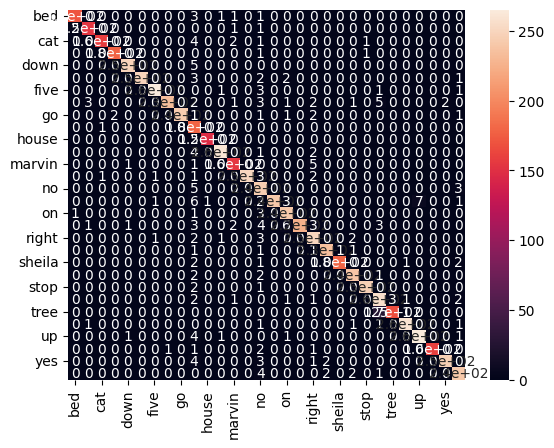

In [40]:
import matplotlib.pyplot as plt
hm = sns.heatmap(data = data, annot=True)
plt.show()

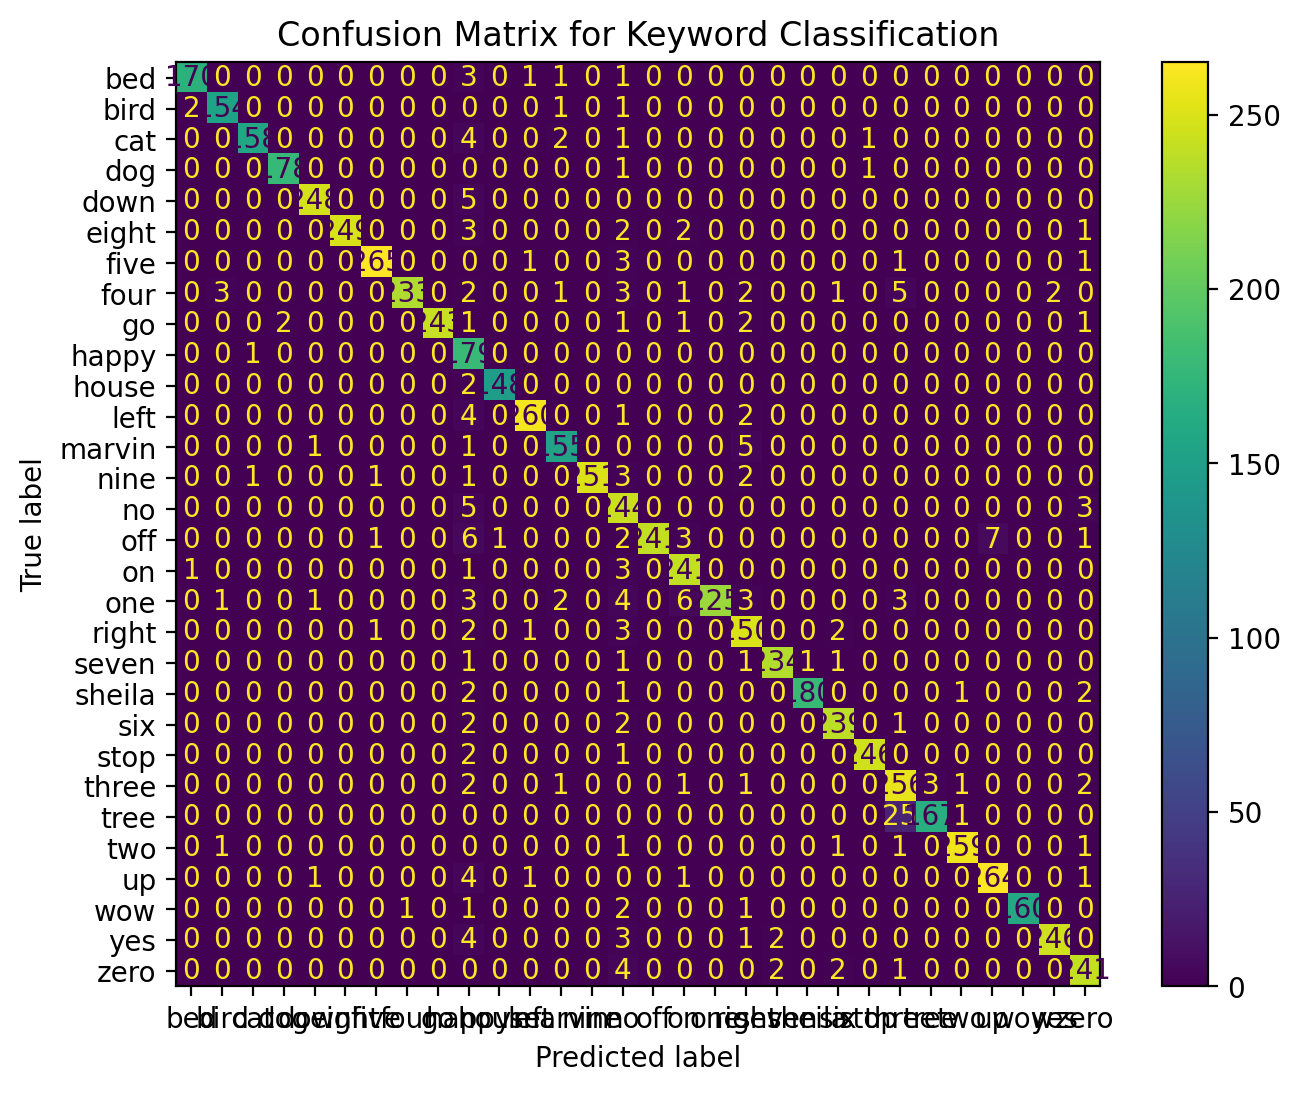

In [39]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(8,6), dpi=200)

display = ConfusionMatrixDisplay(matrix, display_labels=LABELS)

ax.set(title='Confusion Matrix for Keyword Classification')

display.plot(ax=ax);